In [1]:
import os
import copy
import numpy as np
import torch
import einops
import pdb
import ipdb
from diffuser.utils.arrays import batch_to_device, to_np, to_device, apply_dict
from IPython.display import clear_output
import time

pybullet build time: May 20 2022 19:44:17


In [2]:
import diffuser.utils as utils

In [3]:
diffusion = utils.load_diffusion('../logs', 
                                 'maze2d-large-v1', 
                                 'diffusion/H384_T256', 
                                 epoch='latest')
clear_output()

18.07260274887085
Saved 1 samples to: tmp.png


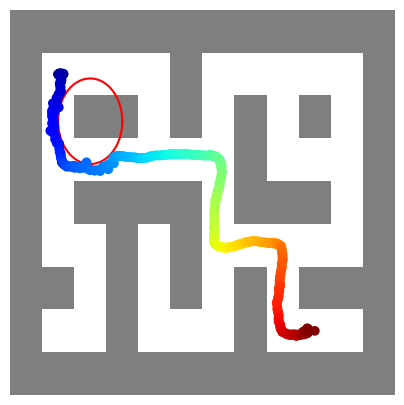

In [5]:
cond = {0: [1, 1, 0, 0], 383: [7, 9, 0, 0]}

cond = utils.apply_dict(
    diffusion.dataset.normalizer.normalize,
    cond,
    'observations'
)
cond = utils.to_torch(cond, dtype=torch.float32, device='cuda:0')
cond = utils.apply_dict(
    einops.repeat,
    cond,
    'd -> repeat d', repeat=1,
)

obst_position = [2.1, 2, 0, 0]
rad = 1

tmp1 = [0, 0, 0, 0]
tmp2 = [rad, rad, 0, 0]
normed_obst = diffusion.dataset.normalizer.normalize(obst_position, 'observations')
tmp1 = diffusion.dataset.normalizer.normalize(tmp1, 'observations')
tmp2 = diffusion.dataset.normalizer.normalize(tmp2, 'observations')

normed_rad = [(tmp2 - tmp1)[0], (tmp2 - tmp1)[1]]

dtau = 1
start = time.time()
samples = diffusion.ema.cbf_sample_vec(cond, cx=normed_obst[0], cy=normed_obst[1], radius=normed_rad, dtau=dtau)
end = time.time()
print(end-start)
samples = to_np(samples)
normed_observations = samples[:, :, 2:]
normed_conditions = to_np(cond[0])[:,None]
normed_observations = np.concatenate([
    np.repeat(normed_conditions, 1, axis=0),
    normed_observations
    ], axis=1)
observations = diffusion.dataset.normalizer.unnormalize(normed_observations, 'observations')
images = diffusion.renderer.composite('tmp.png', observations, ncol=1,
                                      obst_pos=np.array(obst_position[:2]), obst_rad=rad)